In [ ]:
importimportimportimportimportimport re
import numpy as np
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
def text_preprocessing(file_path, min_freq=5):
    with open(file_path, 'r', encoding='windows-1251') as file:
        text = file.read()
    text = re.sub(r'[^а-яА-ЯёЁ]', ' ', text).lower()
    tokens = text.split()
    freq = Counter(tokens)
    tokens = [token for token in tokens if freq[token] >= min_freq]
    return tokens

In [ ]:
def preprocess_sentence(sentence):
    text = re.sub(r'[^а-яА-ЯёЁ]', ' ', sentence).lower()
    tokens = text.split()
    return tokens

In [ ]:
def generate_training_data(tokens, window_size, k, vocab, word_to_idx, sampling_probs):
    num_tokens = len(tokens)
    vocab_size = len(vocab)

    token_indices = np.array([word_to_idx.get(token, word_to_idx["<UNK>"]) for token in tokens])

    w_indices = []
    c_indices = []
    labels = []

    for i in range(num_tokens):
        start = max(0, i - window_size)
        end = min(num_tokens, i + window_size + 1)
        context_indices = np.arange(start, end)
        context_indices = context_indices[context_indices != i]

        num_context = len(context_indices)
        if num_context == 0:
            continue

        w_idx = np.full(num_context, token_indices[i])
        c_pos_idx = token_indices[context_indices]

        neg_indices = np.random.choice(
            vocab_size,
            size=num_context * k,
            p=sampling_probs,
            replace=False
        )
        neg_indices = [idx for idx in neg_indices if idx != token_indices[i]]

        w_neg = np.full(len(neg_indices), token_indices[i])
        c_neg = neg_indices

        w_indices.append(w_idx)
        c_indices.append(c_pos_idx)
        labels.append(np.ones(num_context, dtype=np.int32))

        w_indices.append(w_neg)
        c_indices.append(c_neg)
        labels.append(np.zeros(len(neg_indices), dtype=np.int32))

    w_indices = np.concatenate(w_indices)
    c_indices = np.concatenate(c_indices)
    labels = np.concatenate(labels)

    return list(zip(w_indices, c_indices, labels))

In [ ]:
class Word2Vec:
    def __init__(self, vocab, embedding_dim=300, window_size=5, k=3):
        self.vocab = vocab
        self.word_to_idx = {word: idx for idx, word in enumerate(vocab)}
        self.idx_to_word = {idx: word for word, idx in self.word_to_idx.items()}
        self.vocab_size = len(vocab)
        self.embedding_dim = embedding_dim
        self.window_size = window_size
        self.k = k
        self.l2_lambda = 0.001

        self.W = np.random.randn(self.vocab_size, embedding_dim) / np.sqrt(embedding_dim)
        self.C = np.random.randn(self.vocab_size, embedding_dim) / np.sqrt(embedding_dim)

        if "<UNK>" not in self.word_to_idx:
            self.vocab.append("<UNK>")
            self.word_to_idx["<UNK>"] = self.vocab_size
            self.idx_to_word[self.vocab_size] = "<UNK>"
            self.vocab_size += 1

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def calculate_perplexity(self, validation_data):
        total_loss = 0
        num_samples = 0
        for w_idx, c_idx, label in validation_data:
            dot_product = np.dot(self.C[c_idx], self.W[w_idx])
            prob = self.sigmoid(dot_product)
            loss = - (label * np.log(prob + 1e-10) + (1 - label) * np.log(1 - prob + 1e-10))
            total_loss += loss
            num_samples += 1
        return np.exp(total_loss / num_samples) if num_samples > 0 else float('inf')

    def train(self, training_data, validation_data, learning_rate=0.005, epochs=10):
        best_perplexity = float('inf')
        patience = 3
        no_improvement = 0
        losses = []
        perplexities = []

        for epoch in range(epochs):
            np.random.shuffle(training_data)
            total_loss = 0
            num_samples = 0

            for w_idx, c_idx, label in training_data:
                dot = np.dot(self.C[c_idx], self.W[w_idx])
                s = self.sigmoid(dot)

                loss = -np.log(s + 1e-10) if label == 1 else -np.log(1 - s + 1e-10)
                total_loss += loss
                num_samples += 1

                if label == 1:
                    grad_c = (s - 1) * self.W[w_idx] + self.l2_lambda * self.C[c_idx]
                    grad_w = (s - 1) * self.C[c_idx] + self.l2_lambda * self.W[w_idx]
                else:
                    grad_c = s * self.W[w_idx] + self.l2_lambda * self.C[c_idx]
                    grad_w = s * self.C[c_idx] + self.l2_lambda * self.W[w_idx]

                self.C[c_idx] -= learning_rate * grad_c
                self.W[w_idx] -= learning_rate * grad_w

            avg_loss = total_loss / num_samples if num_samples > 0 else 0
            current_perplexity = self.calculate_perplexity(validation_data)
            losses.append(avg_loss)
            perplexities.append(current_perplexity)

            '''
            # Early stopping
            if current_perplexity < best_perplexity:
                best_perplexity = current_perplexity
                no_improvement = 0
            else:
                no_improvement += 1
                if no_improvement >= patience:
                    print(f"Ранняя остановка на эпохе {epoch}")
                    break
            '''
            print(f"Эпоха {epoch}: Loss={avg_loss:.4f}, Perplexity={current_perplexity:.4f}")

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(losses, marker='o', color='blue')
        plt.title('Кривая обучения')
        plt.xlabel('Эпоха')
        plt.ylabel('Loss')

        plt.subplot(1, 2, 2)
        plt.plot(perplexities, marker='o', color='green')
        plt.title('Перплексия')
        plt.xlabel('Эпоха')
        plt.ylabel('Perplexity')
        plt.show()

    def get_embedding(self, word):
        idx = self.word_to_idx.get(word, self.word_to_idx["<UNK>"])
        return self.W[idx]

In [ ]:
class NeuralLanguageModel:
    def __init__(self, vocab_size, d, d_h, N, word2vec_embeddings, word_to_idx):
        self.vocab_size = vocab_size
        self.d = d
        self.d_h = d_h
        self.N = N
        self.unk_token = "<UNK>"

        self.model = Sequential([
            Embedding(
                input_dim=vocab_size,
                output_dim=d,
                input_length=N,
                weights=[word2vec_embeddings],
                trainable=True
            ),
            Flatten(),
            Dense(d_h, activation='relu', kernel_regularizer=l2(0.01)),
            Dense(d_h // 2, activation='relu', kernel_regularizer=l2(0.01)),
            Dense(vocab_size, activation='softmax')
        ])

        self.model.compile(
            optimizer=Adam(learning_rate=0.0001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        if self.unk_token not in word_to_idx:
            raise ValueError("UNK токен отсутствует в словаре")
        self.word_to_idx = word_to_idx

    def train(self, tokens, val_split=0.2, epochs=10, batch_size=4):
        X, y = [], []
        for t in range(self.N, len(tokens)):
            context = [self.word_to_idx.get(tokens[t - self.N + i], self.word_to_idx[self.unk_token])
                      for i in range(self.N)]
            target = self.word_to_idx.get(tokens[t], self.word_to_idx[self.unk_token])
            X.append(context)
            y.append(target)

        X = np.array(X)
        y = np.array(y)

        #early_stop = EarlyStopping(monitor='val_loss', patience=3)
        history = self.model.fit(
            X, y,
            validation_split=val_split,
            epochs=epochs,
            batch_size=batch_size,
            #callbacks=[early_stop],
            verbose=1
        )

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train')
        plt.plot(history.history['val_loss'], label='Validation')
        plt.title('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Train')
        plt.plot(history.history['val_accuracy'], label='Validation')
        plt.title('Accuracy')
        plt.legend()
        plt.show()

    def predict(self, sentence, idx_to_word):
        tokens = preprocess_sentence(sentence)
        if len(tokens) < self.N:
            return f"Требуется минимум {self.N} слов"

        context = tokens[-self.N:]
        context_idx = [self.word_to_idx.get(word, self.word_to_idx[self.unk_token]) for word in context]
        y_hat = self.model.predict(np.array([context_idx]), verbose=0)[0]
        pred_idx = np.argmax(y_hat)
        return idx_to_word.get(pred_idx, self.unk_token)

In [ ]:
def generate_text(context, model, size, token=False):
    result = context.copy()[:model.window_size]
    current_context = result[:]
    for _ in range(size):
        next_word = model.predict_next_word(current_context, token=token)
        if isinstance(next_word, str) and next_word.startswith("Error"):
            return result
        result.append(next_word)
        current_context = result[-model.window_size:]
    return result

In [ ]:
tokens = text_preprocessing("input.txt", min_freq=5)

vocab = sorted(list(set(tokens)))
if "<UNK>" not in vocab:
    vocab.append("<UNK>")
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

freq = Counter(tokens)
freq_list = [freq[word] for word in vocab]
P = [f**0.75 for f in freq_list]
Z = sum(P)
sampling_probs = [p/Z for p in P]

In [ ]:
window_size = 5
k = 2

training_data = generate_training_data(
        tokens[:len(tokens)//2],
        window_size,
        k,
        vocab,
        word_to_idx,
        sampling_probs
    )
validation_data = generate_training_data(
    tokens[len(tokens)//2:],
    window_size,
    k,
    vocab,
    word_to_idx,
    sampling_probs
)

Эпоха 0: Loss=0.6912, Perplexity=1.9898
Эпоха 1: Loss=0.6781, Perplexity=1.9673
Эпоха 2: Loss=0.6587, Perplexity=1.9452
Эпоха 3: Loss=0.6405, Perplexity=1.9305
Эпоха 4: Loss=0.6263, Perplexity=1.9213
Эпоха 5: Loss=0.6151, Perplexity=1.9149
Эпоха 6: Loss=0.6058, Perplexity=1.9114
Эпоха 7: Loss=0.5978, Perplexity=1.9088
Эпоха 8: Loss=0.5907, Perplexity=1.9068
Эпоха 9: Loss=0.5843, Perplexity=1.9069
Эпоха 10: Loss=0.5786, Perplexity=1.9066
Эпоха 11: Loss=0.5732, Perplexity=1.9066
Эпоха 12: Loss=0.5682, Perplexity=1.9078
Эпоха 13: Loss=0.5635, Perplexity=1.9086
Эпоха 14: Loss=0.5590, Perplexity=1.9105


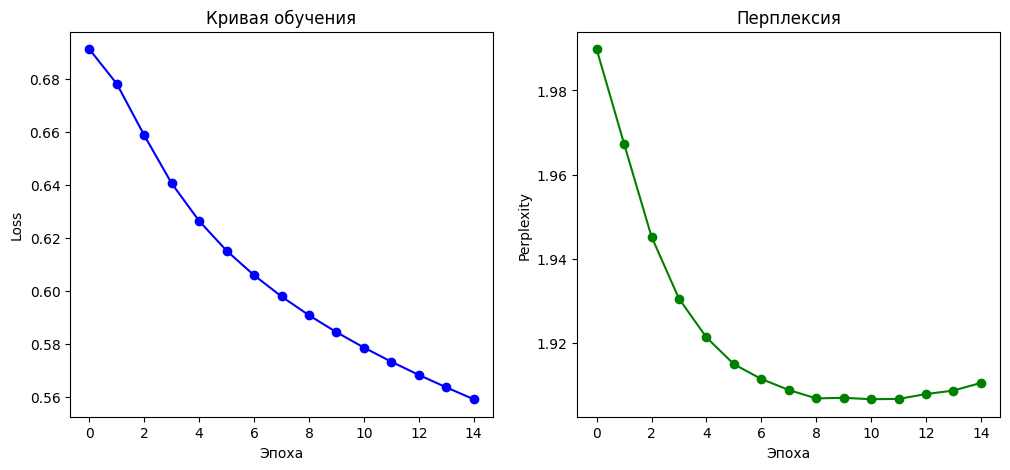

In [ ]:
embedding_dim = 100
d_h = 500
N = 3

word2vec_1 = Word2Vec(vocab, embedding_dim, window_size, k)
word2vec_1.train(training_data, validation_data, epochs=15)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
4534/4534 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.0593 - loss: 8.3765 - val_accuracy: 0.0719 - val_loss: 5.8297
Epoch 2/10
4534/4534 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.0661 - loss: 5.6510 - val_accuracy: 0.0719 - val_loss: 5.7611
Epoch 3/10
4534/4534 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.0650 - loss: 5.6059 - val_accuracy: 0.0750 - val_loss: 5.7609
Epoch 4/10
4534/4534 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.0695 - loss: 5.5474 - val_accuracy: 0.0739 - val_loss: 5.7557
Epoch 5/10
4534/4534 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.0726 - loss: 5.5111 - val_accuracy: 0.0759 - val_loss: 5.7430
Epoch 6/10
4534/4534 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.0702 - loss: 5.4848 - val_accuracy: 0.0772 - val_loss: 5.7410
Epoch 7/10
4534/4534 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.0710 - loss: 5.4594 - val_accuracy: 0.0741 - val_loss: 5.7313
Epoch 8/10
4534/4534 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.0734 - loss: 5

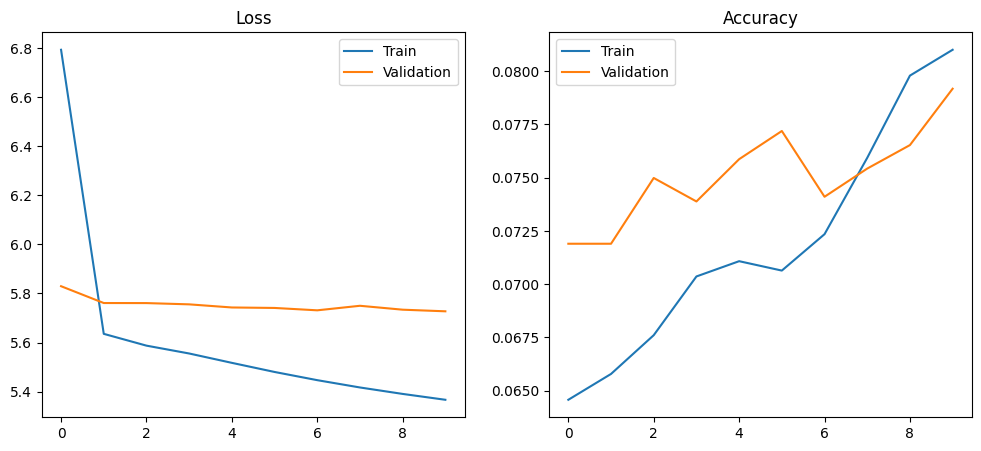

In [ ]:
model_1 = NeuralLanguageModel(
    vocab_size=len(vocab),
    d=embedding_dim,
    d_h=d_h,
    N=N,
    word2vec_embeddings=word2vec_1.W,
    word_to_idx=word_to_idx
)
model_1.train(tokens, epochs=10)

In [ ]:
test_sentence = "в школе учился"
predicted = model_1.predict(test_sentence, idx_to_word)
print(f"Прогноз: '{test_sentence}' -> {predicted}")

Прогноз: 'в школе учился' -> и


Эпоха 0: Loss=0.6788, Perplexity=1.9358
Эпоха 1: Loss=0.6386, Perplexity=1.8903
Эпоха 2: Loss=0.6149, Perplexity=1.8707
Эпоха 3: Loss=0.5999, Perplexity=1.8598
Эпоха 4: Loss=0.5887, Perplexity=1.8525
Эпоха 5: Loss=0.5794, Perplexity=1.8477
Эпоха 6: Loss=0.5712, Perplexity=1.8445
Эпоха 7: Loss=0.5637, Perplexity=1.8427
Эпоха 8: Loss=0.5568, Perplexity=1.8410
Эпоха 9: Loss=0.5503, Perplexity=1.8410


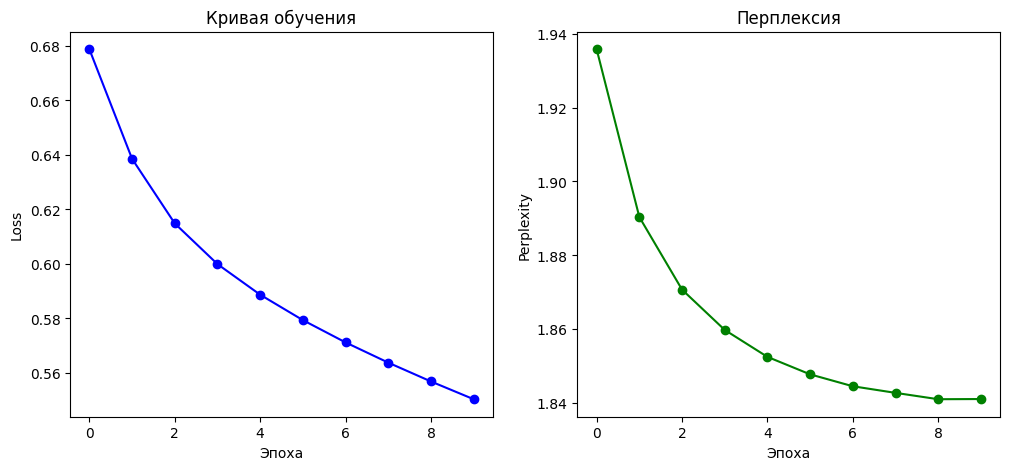

Epoch 1/10
45734/45734 ━━━━━━━━━━━━━━━━━━━━ 2589s 57ms/step - accuracy: 0.0557 - loss: 7.2732 - val_accuracy: 0.0568 - val_loss: 6.6840
Epoch 2/10
45734/45734 ━━━━━━━━━━━━━━━━━━━━ 2661s 58ms/step - accuracy: 0.0649 - loss: 6.5348 - val_accuracy: 0.0690 - val_loss: 6.5921
Epoch 3/10
45734/45734 ━━━━━━━━━━━━━━━━━━━━ 2651s 58ms/step - accuracy: 0.0721 - loss: 6.4303 - val_accuracy: 0.0700 - val_loss: 6.5640
Epoch 4/10
 8436/45734 ━━━━━━━━━━━━━━━━━━━━ 34:34 56ms/step - accuracy: 0.0754 - loss: 6.3705

KeyboardInterrupt: 

In [ ]:




embeddingembedding_dim = 500

word2vec_2 = Word2Vec(vocab, embedding_dim, window_size, k)
word2vec_2.train(training_data, validation_data, epochs=10)

model_2 = NeuralLanguageModel(
    vocab_size=len(vocab),
    d=embedding_dim,
    d_h=d_h,
    N=N,
    word2vec_embeddings=word2vec_2.W,
    word_to_idx=word_to_idx
)
model_2.train(tokens, epochs=10)

In [ ]:
test_sentence = "почти каждый день"
predicted = model_2.predict(test_sentence, idx_to_word)
print(f"Прогноз: '{test_sentence}' -> {predicted}")

In [ ]:
embedding_dim = 1000

word2vec_3 = Word2Vec(vocab, embedding_dim, window_size, k)
word2vec_3.train(training_data, validation_data, epochs=10)

model_3 = NeuralLanguageModel(
    vocab_size=len(vocab),
    d=embedding_dim,
    d_h=d_h,
    N=N,
    word2vec_embeddings=word2vec_3.W,
    word_to_idx=word_to_idx
)
model_3.train(tokens, epochs=10)

In [ ]:
test_sentence = "я хочу пойти гулять"
predicted = model_3.predict(test_sentence, idx_to_word)
print(f"Прогноз: '{test_sentence}' -> {predicted}")